# Homework 1

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

### Data

This homework uses the data file, `treasury_quotes_2024-10-31`.

The problems below analyze the nominal, (rather than the TIPS,) Treasury issues. Accordingly, you should filter out all rows with `type` `TIPS Note` or `TIPS bond`.

***

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import skew,kurtosis,norm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import interpolate


file = "../../data/treasury_quotes_2024-10-31.xlsx"
# file = r"C:\Users\josel\Documents\GitHub\finm-fixedincome-2025\data\treasury_quotes_2024-10-31.xlsx"

treasury_quotes_2024_10_31_quotes = pd.read_excel(file, sheet_name= "quotes")
# treasury_quotes_2024_10_31_quotes = treasury_quotes_2024_10_31_quotes[~treasury_quotes_2024_10_31_quotes["type"].isin(["TIPS note", "TIPS bond"])]

treasury_quotes_2024_10_31_selected_quotes = pd.read_excel(file, sheet_name= "selected quotes")


In [29]:
from datetime import datetime

def get_coupon_dates(quote_date, maturity_date):

    if isinstance(quote_date, str):
        quote_date = datetime.strptime(quote_date, '%Y-%m-%d')
    if isinstance(maturity_date, str):
        maturity_date = datetime.strptime(maturity_date, '%Y-%m-%d')
    
    if quote_date >= maturity_date:
        raise ValueError("Quote date must be earlier than maturity date.")

    semiannual_offset = pd.DateOffset(months=6)
    dates = []
    current_date = maturity_date

    while current_date > quote_date:
        dates.append(current_date)
        current_date -= semiannual_offset

    return sorted(dates)
def calc_cashflows(data, adj_end_month = False):

    columns = ["CALDT", "TMATDT", "ITYPE", "TDYLD"]
    quote_data = data.copy()
    
    if quote_data.columns.isin(columns).sum() != len(columns):
        quote_data.rename(columns={"quote date":"CALDT", "maturity date":"TMATDT", "type":"ITYPE", "ytm":"TDYLD", "cpn rate": "TCOUPRT"}, inplace=True) 
    
    CF = pd.DataFrame(data=0.0, index=quote_data.index, columns=quote_data['TMATDT'].unique(), dtype=float)


    for i in quote_data.index:
        coupon_dates = get_coupon_dates(quote_data.loc[i,'CALDT'],quote_data.loc[i,'TMATDT'])

        if coupon_dates is not None:
            CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2

        CF.loc[i,quote_data.loc[i,'TMATDT']] += 100

    if adj_end_month:
        CF = CF.T.resample('ME').sum().T
        CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)
        CF = CF.fillna(0).sort_index(axis=1)

    else:
        CF = CF.fillna(0).sort_index(axis=1)
        CF.drop(columns=CF.columns[(CF==0).all()],inplace=True)

        
    return CF


def discount_to_intrate(discount, maturity, n_compound=None):
        
    if n_compound is None:
        intrate = - np.log(discount) / maturity
    
    else:
        intrate = n_compound * (1/discount**(1/(n_compound * maturity)) - 1)    
        
    return intrate

def intrate_to_discount(intrate, maturity, n_compound=None):
    
    if n_compound is None:
        discount = np.exp(-intrate * maturity)
    else:
        discount = 1 / (1+(intrate / n_compound))**(n_compound * maturity)

    return discount   

def compound_rate(intrate,compound_input,compound_output):    
    if compound_input is None:
        outrate = compound_output * (np.exp(intrate/compound_output) - 1)
    elif compound_output is None:
        outrate = compound_input * np.log(1 + intrate/compound_input)
    else:
        outrate = ((1 + intrate/compound_input) ** (compound_input/compound_output) - 1) * compound_output

    return outrate

def filter_treasury_cashflows(CF, filter_maturity_dates=False, filter_benchmark_dates=False, filter_CF_strict=True):

    mask_benchmark_dts = []
    
    # Filter by using only benchmark treasury dates
    for col in CF.columns:
        if filter_benchmark_dates:
            if col.month in [2,5,8,11] and col.day == 15:
                mask_benchmark_dts.append(col)
        else:
            mask_benchmark_dts.append(col)
    
    if filter_maturity_dates:
        mask_maturity_dts = CF.columns[(CF>=100).any()]
    else:
        mask_maturity_dts = CF.columns
    
    mask = [i for i in mask_benchmark_dts if i in mask_maturity_dts]

    CF_filtered = CF[mask]
          
    if filter_CF_strict:
        # drop issues that had CF on excluded dates
        mask_bnds = CF_filtered.sum(axis=1) == CF.sum(axis=1)
        CF_filtered = CF_filtered[mask_bnds]

    else:
        # drop issues that have no CF on included dates
        mask_bnds = CF_filtered.sum(axis=1) > 0
        CF_filtered = CF_filtered[mask_bnds]
        
        
    # update to drop dates with no CF
    CF_filtered = CF_filtered.loc[:,(CF_filtered>0).any()]
    
    return CF_filtered
def filter_treasuries(data, t_date=None, filter_maturity = None, filter_maturity_min=None, drop_duplicate_maturities = False, filter_tips=True, filter_yld=True):
    
    columns = ["CALDT", "TMATDT", "ITYPE", "TDYLD"]
    
    if data.columns.isin(columns).sum() != len(columns):
        outdata = data.copy()
        outdata.rename(columns={"quote date":"CALDT", "maturity date":"TMATDT", "type":"ITYPE", "ytm":"TDYLD"}, inplace=True) 

        outdata = outdata[outdata['ITYPE'].str.contains('TIPS') == (not filter_tips)]
        reversed_name = True
    else:
        outdata = data.copy()
        outdata = outdata[outdata['ITYPE'].isin([11,12]) == (not filter_tips)]
        reversed_name = False


    if t_date is None:
        t_date = outdata['CALDT'].values[-1]
    
    outdata = outdata[outdata['CALDT'] == t_date]
    
    # Filter out redundant maturity
    if drop_duplicate_maturities:
        outdata = outdata.drop_duplicates(subset=['TMATDT'])
    
    # Filter by max maturity
    if filter_maturity is not None:
        mask_truncate = outdata['TMATDT'] < (t_date + np.timedelta64(365*filter_maturity+1,'D'))
        outdata = outdata[mask_truncate]

    # Filter by min maturity
    if filter_maturity_min is not None:
        mask_truncate = outdata['TMATDT'] > (t_date + np.timedelta64(365*filter_maturity_min-1,'D'))
        outdata = outdata[mask_truncate]

        
    if filter_yld:
        outdata = outdata[outdata['TDYLD']>0]
    
    if reversed_name:
        outdata.rename(columns={"CALDT":"quote date", "TMATDT":"maturity date", "ITYPE":"type", "TDYLD":"ytm"}, inplace=True)
    return outdata
import numpy as np
import pandas as pd
from scipy.optimize import minimize

def estimate_nelson_siegel_models(CF, t_current, prices, 
                                  x0_ns=None, x0_nse=None, 
                                  return_modeled_prices=False):



    col_dates = pd.to_datetime(CF.columns)
    t_val = pd.to_datetime(t_current)
    maturity = (col_dates - t_val).days / 365.25

    if isinstance(prices, pd.Series):
        y = prices.values
    else:
        y = np.array(prices)

    def nelson_siegel(p, m):
        # p = [beta0, beta1, beta2, lambda]
        num = (1 - np.exp(-m/p[3]))
        denom = np.where(np.isclose(m, 0), 1e-12, (m/p[3]))
        return p[0] + (p[1] + p[2])*(num/denom) - p[2]*np.exp(-m/p[3])

    def nelson_siegel_extended(p, m):
        # p = [beta0, beta1, beta2, lambda1, beta3, lambda2]
        num1 = (1 - np.exp(-m/p[3]))
        den1 = np.where(np.isclose(m, 0), 1e-12, (m/p[3]))
        num2 = (1 - np.exp(-m/p[5]))
        den2 = np.where(np.isclose(m, 0), 1e-12, (m/p[5]))
        return (p[0]
                + (p[1] + p[2])*(num1/den1)
                - p[2]*np.exp(-m/p[3])
                + p[4]*( (num2/den2) - np.exp(-m/p[5]) ))

    def model_price(params, model):
        # Continuous discount from the rates
        rates = model(params, maturity)
        discs = np.exp(-rates*maturity)
        return CF.values @ discs, pd.DataFrame(data=discs, index=maturity, columns=["Discount Factor"])

    def sse_loss(params, model):
        mp = model_price(params, model)[0]
        return np.sum((y - mp)**2)


    if x0_ns is None:
        # [beta0, beta1, beta2, lambda]
        x0_ns = np.ones(4)/10
    res_ns = minimize(sse_loss, x0_ns, args=(nelson_siegel,))
    ns_params = res_ns.x

    # Fit Extended NS with x0_nse = np.concatenate( (ns_params, [0.1, 0.1]) )
    if x0_nse is None:
        # [beta0, beta1, beta2, lambda1, beta3, lambda2]
        x0_nse = np.concatenate((ns_params,(1/10,1/10)))
    res_nse = minimize(sse_loss, x0_nse, args=(nelson_siegel_extended,))
    nse_params = res_nse.x


    df_params = pd.DataFrame(
        index=["Nelson-Siegel", "Nelson-Siegel Extended"],
        columns=["theta 0","theta 1","theta 2","lambda_1","theta_3","lambda_2"]
    )


    df_params.loc["Nelson-Siegel", ["theta 0","theta 1","theta 2","lambda_1"]] = ns_params
    df_params.loc["Nelson-Siegel", ["theta_3","lambda_2"]] = [None, None]

    df_params.loc["Nelson-Siegel Extended", :] = nse_params

    out = {"params": df_params}
    if return_modeled_prices:
        out["DF_ns"] = model_price(ns_params, nelson_siegel)[1]
        out["DF_nse"] = model_price(nse_params, nelson_siegel_extended)[1]

    return out

# 1. Discount Rates

Use the data in the `selected quotes` tab.

Note:
* The selected treasuries are at nearly six-month intervals. 
* If you prefer, approximate that they mature at perfect 6-month intervals. 

### 1.1.

Create the cashflow matrix, $\textbf{C}$, where each rows is a Treasury issue, each column is a date, and each entry is the cash paid on a (normalized) face value of \$100.

In [30]:
# treasury_quotes_2024_10_31_selected_quotes.set_index('KYTREASNO',inplace=True)
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_REDUNDANT = True

data = filter_treasuries(treasury_quotes_2024_10_31_selected_quotes, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)


RESTRICT_DTS_MATURING = True

Cash_Flows = filter_treasury_cashflows(calc_cashflows(data, adj_end_month = True), filter_maturity_dates=True)
display(Cash_Flows)

,2025-04-30,2025-10-31,2026-04-30,2026-10-31,2027-04-30,2027-10-31,2028-04-30,2028-10-31,2029-04-30,2029-10-31,2030-04-30,2030-10-31,2031-04-30,2031-10-31
0,101.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2.5000,102.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,1.3750,1.3750,1.3750,1.3750,101.3750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,1.7500,1.7500,1.7500,1.7500,1.7500,1.7500,101.7500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,2.4375,102.4375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
8,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,2.3125,102.3125,0.0000,0.0000,0.0000,0.0000,0.0000
9,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,2.0625,102.0625,0.0000,0.0000,0.0000,0.0000


### 1.2.

Estimate the spot discount factors that rationalize the market prices of the treasuries. Do this via solving the linear system

$$\textbf{p} = {\textbf{C}}\, \textbf{z}$$

We can calculate $\hat{z}$ only by multiplite both side by $C^{-1}$, leaving:

$$\hat{z} = C^{-1}p$$ 

In [31]:
p = treasury_quotes_2024_10_31_selected_quotes["price"].values
C = Cash_Flows.values

In [32]:
z_hat = np.linalg.inv(C) @ p
Discount_Factor = pd.DataFrame( [Cash_Flows.columns,z_hat], index=["Maturity", "Discount_Factor"]).T
Discount_Factor["Maturity"] = pd.to_datetime(Discount_Factor["Maturity"])
Discount_Factor["Discount_Factor"] = pd.to_numeric(Discount_Factor["Discount_Factor"])
display(Discount_Factor)

,Maturity,Discount_Factor
0,2025-04-30,0.978220
1,2025-10-31,0.958103
2,2026-04-30,0.939358
3,2026-10-31,0.921067
4,2027-04-30,0.903034
5,2027-10-31,0.884856
6,2028-04-30,0.866327
7,2028-10-31,0.848120
8,2029-04-30,0.831110
9,2029-10-31,0.814462


Because we are working with a lower triangular matrix, if we estimate a linear regression is going to be the same result and the errors of the regression are equal to zero 

In [33]:
mod = sm.OLS(p, C).fit()
Discount_Factor = pd.DataFrame( [Cash_Flows.columns, mod.params], index=["Maturity", "Discount_Factor"]).T
Discount_Factor["Maturity"] = pd.to_datetime(Discount_Factor["Maturity"])
Discount_Factor["Discount_Factor"] = pd.to_numeric(Discount_Factor["Discount_Factor"])
display(Discount_Factor)

,Maturity,Discount_Factor
0,2025-04-30,0.978220
1,2025-10-31,0.958103
2,2026-04-30,0.939358
3,2026-10-31,0.921067
4,2027-04-30,0.903034
5,2027-10-31,0.884856
6,2028-04-30,0.866327
7,2028-10-31,0.848120
8,2029-04-30,0.831110
9,2029-10-31,0.814462


### 1.3.

Plot the time-to-maturity on the horizontal axis. On the vertical axis, plot the...
* discount factors

Make another plot, this time with the vertical axis displaying the
* semiannually compounded discount rates
* continuously compounded discount rates

Text(0.5, 1.0, 'Discount Factor vs Maturity')

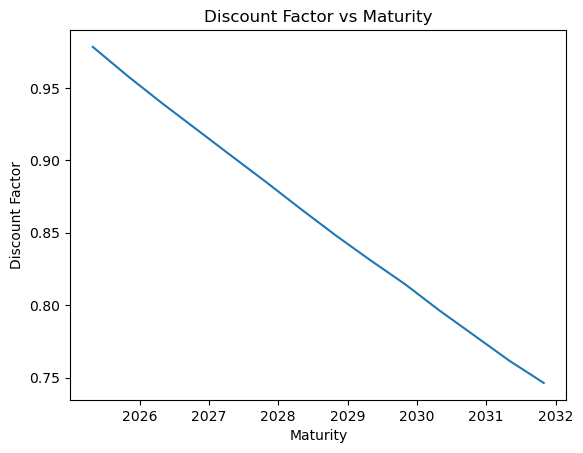

In [34]:
plt.plot(Discount_Factor["Maturity"], Discount_Factor["Discount_Factor"])
plt.xlabel("Maturity")  
plt.ylabel("Discount Factor")
plt.title("Discount Factor vs Maturity")

Text(0.5, 1.0, 'SemiAnual and Continuously Rate vs Maturity')

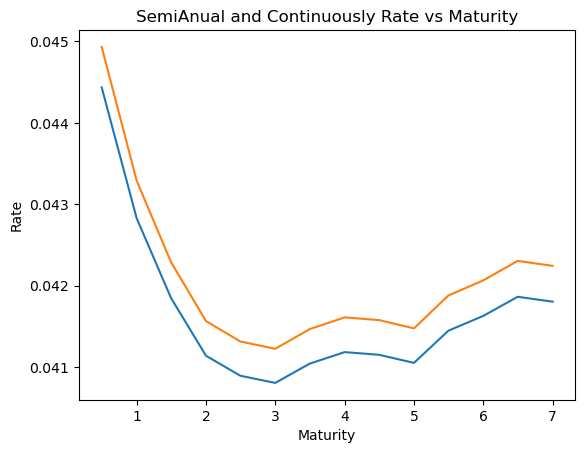

In [35]:
quote_date = treasury_quotes_2024_10_31_selected_quotes["quote date"].min()

Discount_Factor["T"] = treasury_quotes_2024_10_31_selected_quotes["ttm"].values
Discount_Factor["Continuously_Rate"] = -np.log(Discount_Factor["Discount_Factor"])/Discount_Factor["T"]
Discount_Factor["SemiAnual_Rate"] = compound_rate(Discount_Factor["Continuously_Rate"],None,2)

plt.plot(Discount_Factor["T"], Discount_Factor["Continuously_Rate"])


plt.plot(Discount_Factor["T"], Discount_Factor["SemiAnual_Rate"])
plt.xlabel("Maturity")
plt.ylabel("Rate")
plt.title("SemiAnual and Continuously Rate vs Maturity")


### 1.4.

Suppose that all discount rates and all coupon rates go up by 0.5\%. 

Calculate the new price of each of the treasury securities, using present value pricing.

In [36]:
Discount_Factor_adj = Discount_Factor.copy()
Discount_Factor_adj["SemiAnual_Rate"] = Discount_Factor_adj["SemiAnual_Rate"] + 0.5/100
Discount_Factor_adj["Adj_Discount_Factor"] = (1 + Discount_Factor_adj["SemiAnual_Rate"]/2) ** (-2 * Discount_Factor_adj["T"])

lower_triangular = np.tril(np.full((len(C), len(C)), 0.5)) # It does not divide by 100
C_5bps = C + lower_triangular/2

p_5bps = C_5bps @ Discount_Factor_adj["Adj_Discount_Factor"].values

In [37]:
pd.DataFrame(p_5bps, columns=["Price_5bps"], index=data.index)

,Price_5bps
0,99.720256
1,100.648984
2,100.942717
3,99.937669
4,96.790333
5,100.003602
6,97.942614
7,102.575685
8,101.891044
9,99.895547


***

# 2. Estimating the Discount Curve with Real Data

Use the data in the `quotes` tab.

### 2.1. Map Cashflows

Construct the cashflow matrix.

Given the unfiltered data set, you will need to make a few modeling choices to do this...
* eliminate any treasury that does not report YTM or that reports a negative YTM.
* assume notes and bonds pay coupons every six months, going backward from the date of maturity.

Make other reasonable modeling assumptions as needed.

Report:
* head and tail rows of the dataframe, $\textbf{C}$, for instance, using `display()`.

* which date has the most cashflow across all issues?

* which date has the most issues paying a cashflow?

In [38]:
treasury_quotes_2024_10_31_quotes.set_index('KYTREASNO',inplace=True)
treasury_quotes_2024_10_31_quotes.sort_values(by="maturity date", inplace=True)

In [39]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_REDUNDANT = False

data = filter_treasuries(treasury_quotes_2024_10_31_quotes, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)


In [43]:
CF = calc_cashflows(data)

In [44]:
i = "2024-11-05"
count_cashflows = pd.DataFrame(data=0, index=CF.columns, columns=["count"])
for i in CF.columns:
    n = len(CF.loc[CF[i] > 0, i])
    n_maturity = len(CF.loc[CF[i] >= 100, i])
    count_cashflows.loc[i, "count"] = n
    count_cashflows.loc[i, "Maturities"] = n_maturity

count_cashflows.sort_values(by="count", ascending=False, inplace=True)
print(f"Date with most cashflows: {count_cashflows.index[0]}, Number of cashflows: {count_cashflows.iloc[0,0]}")
display(CF.head())
display(CF.tail())


Date with most cashflows: 2025-02-15 00:00:00, Number of cashflows: 80


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.0,100.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.0,0.0,0.0,100.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0.0,0.0,0.0,0.0,103.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208107,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.0625,0.0000,2.0625,0.0000,102.0625,0.0000,0.000,0.0000,0.000
208149,0.0,0.0,0.0,0.0,2.3750,0.0,0.0,0.0,0.0,0.0,...,2.3750,0.0000,2.3750,0.0000,2.3750,0.0000,102.3750,0.000,0.0000,0.000
208178,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,102.125,0.0000,0.000
208233,0.0,0.0,0.0,0.0,2.3125,0.0,0.0,0.0,0.0,0.0,...,2.3125,0.0000,2.3125,0.0000,2.3125,0.0000,2.3125,0.000,102.3125,0.000
208279,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.1250,0.0000,2.1250,0.0000,2.1250,0.0000,2.125,0.0000,102.125


### 2.2. OLS

Estimate the discount factors using OLS.

Starting with the cashflow matrix, $C$, create an additional filter to get a subset where every date has at least one maturity, (possibly multiple,) and every issue has its maturity in the cashflow matrix. Call this set of cashflows, $\hat{C}$.

**Report 5 head and tail rows of $\hat{C}$.**

$$\textbf{p} = \hat{\textbf{C}}\,\textbf{z}_{\text{ols}}+\epsilon$$

Plot the time-to-maturity vs discount rates, semiannually compounded.

In [45]:
CF_Filter = filter_treasury_cashflows(CF, filter_maturity_dates=True)
display(CF_Filter.head())
display(CF_Filter.tail())

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.0,100.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.0,0.0,0.0,100.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0.0,0.0,0.0,0.0,103.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2032-05-15,2032-08-15,2032-11-15,2033-02-15,2033-05-15,2033-08-15,2033-11-15,2034-02-15,2034-05-15,2034-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208105,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375,0.0000,0.0000,0.0000,0.0000
208147,0.0,0.0,0.0,0.0,2.2500,0.0,0.0,0.0,0.0,0.0,...,2.2500,0.0000,2.2500,0.0000,2.2500,0.0000,102.2500,0.0000,0.0000,0.0000
208177,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,2.0000,0.0000,2.0000,0.0000,2.0000,0.0000,102.0000,0.0000,0.0000
208231,0.0,0.0,0.0,0.0,2.1875,0.0,0.0,0.0,0.0,0.0,...,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,2.1875,0.0000,102.1875,0.0000
208277,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,...,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,1.9375,0.0000,101.9375


In [46]:
prices = treasury_quotes_2024_10_31_quotes.loc[treasury_quotes_2024_10_31_quotes.index.isin(CF_Filter.index),"dirty price"] #Use Dirty Price

In [47]:
mod = sm.OLS(prices, CF_Filter).fit()
Discount_Factor = pd.DataFrame( [CF_Filter.columns, mod.params], index=["Maturity", "Discount_Factor"]).T
Discount_Factor["Maturity"] = pd.to_datetime(Discount_Factor["Maturity"])
Discount_Factor["Discount_Factor"] = pd.to_numeric(Discount_Factor["Discount_Factor"])
display(Discount_Factor)

,Maturity,Discount_Factor
0,2024-11-05,0.999479
1,2024-11-07,0.999224
2,2024-11-12,0.998576
3,2024-11-14,0.998328
4,2024-11-15,0.998187
...,...,...
132,2033-08-15,0.688799
133,2033-11-15,0.681381
134,2034-02-15,0.673716
135,2034-05-15,0.666492


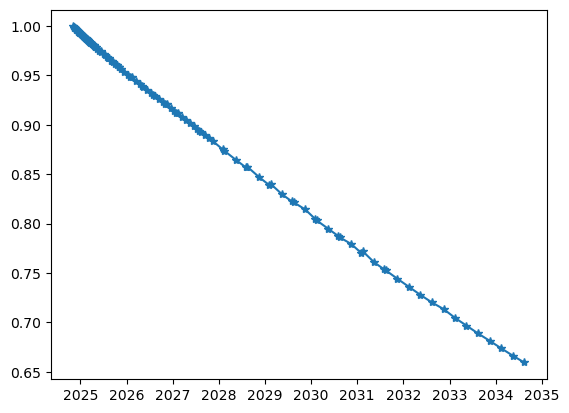

In [48]:
plt.plot(Discount_Factor["Maturity"], Discount_Factor["Discount_Factor"], marker='*')

Text(0.5, 1.0, 'SemiAnual and Continuously Rate vs Maturity')

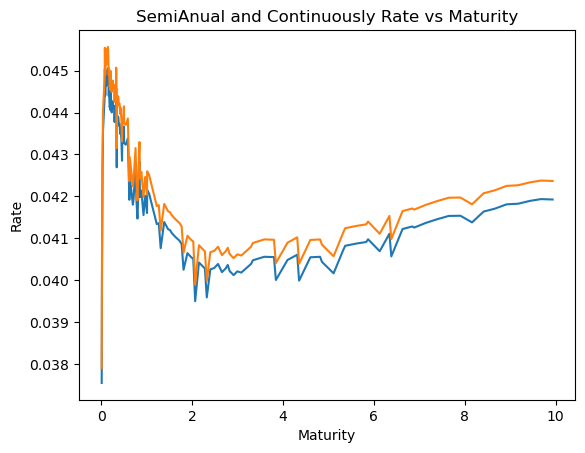

In [49]:
quote_date = treasury_quotes_2024_10_31_quotes["quote date"].min()

Discount_Factor["T"] = ((Discount_Factor["Maturity"] - quote_date).dt.days)/360
Discount_Factor["Continuously_Rate"] = -np.log(Discount_Factor["Discount_Factor"])/Discount_Factor["T"]
Discount_Factor["SemiAnual_Rate"] = compound_rate(Discount_Factor["Continuously_Rate"],None,2)

plt.plot(Discount_Factor["T"], Discount_Factor["Continuously_Rate"])
plt.plot(Discount_Factor["T"], Discount_Factor["SemiAnual_Rate"])
plt.xlabel("Maturity")
plt.ylabel("Rate")
plt.title("SemiAnual and Continuously Rate vs Maturity")



<Axes: xlabel='Maturity'>

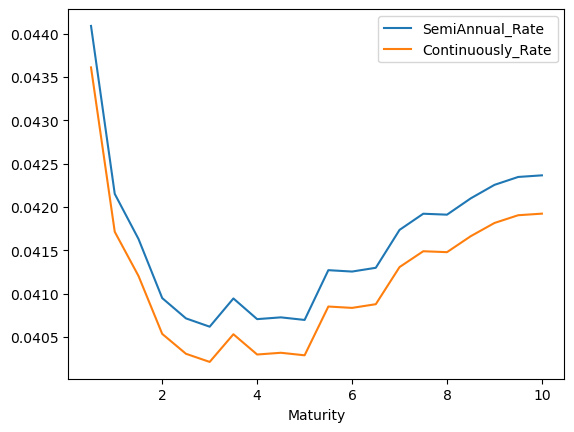

In [50]:
maturity_grid = np.arange(0.5, Discount_Factor["T"].max() + 0.5, 0.5)
f = interpolate.interp1d(Discount_Factor["T"].values, Discount_Factor["SemiAnual_Rate"].values, bounds_error=False, fill_value='extrapolate')
rate_semiannual = f(maturity_grid)
g = interpolate.interp1d(Discount_Factor["T"].values, Discount_Factor["Continuously_Rate"].values, bounds_error=False, fill_value='extrapolate')
rate_continuous = g(maturity_grid)
interpolate_rates = pd.DataFrame([maturity_grid, rate_semiannual, rate_continuous], index=["Maturity", "SemiAnnual_Rate", "Continuously_Rate"]).T
interpolate_rates.index = interpolate_rates["Maturity"]
interpolate_rates.drop(columns=["Maturity"], inplace=True)
interpolate_rates.plot()

### 2.3. EXTRA (not graded)

Re-do `2.2.`, but this time use Weighted Least Squares. Find a weighting scheme that puts more weight on more recently issued treasures and less weight on less recently issued treasures. 

Does your answer change much?


### 2.4. Curve-Fitting

Continue with the model of cashflows (having filtered out some treasuries).

Estimate the discount curve via the Nelson-Siegel model.
* Fit via minimizing the sum of squared errors of the modeled prices against the quoted prices.
* Consider using `minimize` from `scipy.optimize`.

When done,
* Report the estimated NS parameters.
* Plot the semiannually-compounded discount rates along with those estimated with OLS from above.

In [51]:
quote_date = treasury_quotes_2024_10_31_quotes["quote date"].min()

prices = treasury_quotes_2024_10_31_quotes.loc[treasury_quotes_2024_10_31_quotes.index.isin(CF.index),"dirty price"] #Use Prce or Dirty Price


res = estimate_nelson_siegel_models(CF, quote_date, prices, return_modeled_prices=True)

df_params = res['params']
display(df_params)

# Modeled prices
DF_ns = res['DF_ns']
DF_nse = res['DF_nse']


DF_ns["Continuously_Rate"] = -np.log(DF_ns["Discount Factor"])/DF_ns.index
DF_ns["SemiAnual_Rate_NS"] = compound_rate(DF_ns["Continuously_Rate"],None,2)

DF_nse["Continuously_Rate"] = -np.log(DF_nse["Discount Factor"])/DF_nse.index
DF_nse["SemiAnual_Rate_NSE"] = compound_rate(DF_nse["Continuously_Rate"],None,2)

c:\Users\josel\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)
c:\Users\josel\anaconda3\Lib\site-packages\pandas\core\indexes\base.py:945: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*new_inputs, **kwargs)


,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.04789,-0.002237,-0.020375,2.126904,None,None
Nelson-Siegel Extended,0.048571,-0.011136,-0.015606,2.121001,0.056781,0.078159


<Axes: title={'center': 'Semiannually compounded rates'}, xlabel='Maturity'>

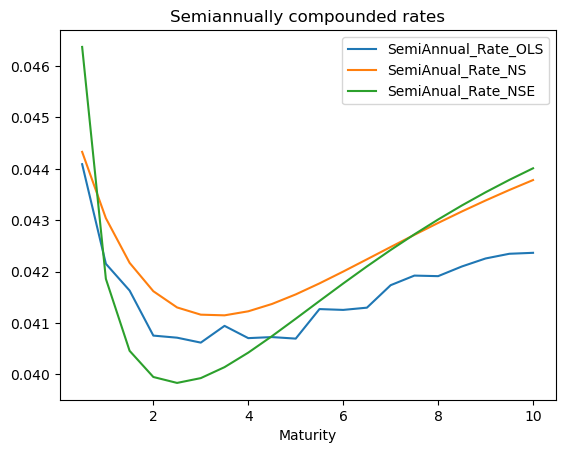

In [96]:
maturity_grid = np.arange(0.5, Discount_Factor["T"].max() + 0.5, 0.5)
f = interpolate.interp1d(Discount_Factor["T"].values, Discount_Factor["SemiAnual_Rate"].values, bounds_error=False, fill_value='extrapolate')
rate_semiannual = f(maturity_grid)
g = interpolate.interp1d(DF_ns.index.values, DF_ns["SemiAnual_Rate_NS"].values, bounds_error=False, fill_value='extrapolate')
SemiAnual_Rate_NS = g(maturity_grid)
h = interpolate.interp1d(DF_nse.index.values, DF_nse["SemiAnual_Rate_NSE"].values, bounds_error=False, fill_value='extrapolate')
SemiAnual_Rate_NSE = h(maturity_grid)

interpolate_rates = pd.DataFrame([maturity_grid, rate_semiannual, SemiAnual_Rate_NS, SemiAnual_Rate_NSE], index=["Maturity", "SemiAnnual_Rate_OLS", "SemiAnual_Rate_NS", "SemiAnual_Rate_NSE"]).T
interpolate_rates.index = interpolate_rates["Maturity"]
interpolate_rates.drop(columns=["Maturity"], inplace=True)
interpolate_rates.plot(title = "Semiannually compounded rates")

***

# 3. Yield-Curve Factors

### Data
This section uses data in `'../data/yields.xlsx`.



In [12]:
import pandas as pd 
import numpy as np
import seaborn as sns

path = "../../data/yields.xlsx"

yields = pd.read_excel(path, sheet_name="yields", index_col=0)
yields.columns = ["1Y", "2Y", "5Y", "7Y", "10Y", "20Y", "30Y"]

In [13]:
yields.head()

,1Y,2Y,5Y,7Y,10Y,20Y,30Y
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


### 3.1. Yield Curve Movements

Use the yield curve time-series data to calculate the time-series of the **level**, **slope**, and **curvature** factors.

Calculate the yield-curve factors. For each point in time, calculate the following three factors:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

Report the 
* correlation matrix of the factors.
* *mean and volatility of the factors.

In [14]:
yields["Level"] = yields.mean(axis=1)
yields["Slope"] = yields["30Y"] - yields["1Y"]
yields["Curvature"] = -yields["1Y"] + 2*yields["10Y"] - yields["30Y"] 

In [15]:
yields[["Level", "Slope", "Curvature"]].describe()

,Level,Slope,Curvature
count,15868.000000,15868.000000,15868.000000
mean,5.463678,1.098446,0.660265
std,2.903979,1.478564,0.975464
min,0.487603,-3.490292,-5.426753
25%,3.464977,-0.021420,0.074945
50%,5.154073,0.997652,0.615611
75%,7.149205,2.109713,1.328883
max,15.259628,4.358273,3.283792


<Axes: >

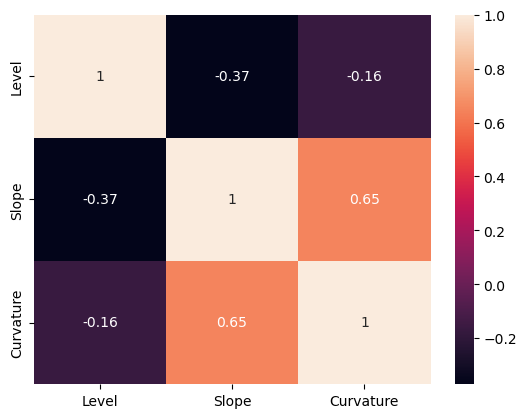

In [16]:
sns.heatmap(yields[["Level", "Slope", "Curvature"]].corr(), annot=True)

### 3.2. PCA

Calculate the principal components of the time-series yield data.

Report...
* the percentage of total variation explained by each factor.
* the loadings of the first two PCA factors.

#### Note
Consider using,
`PCA` from `sklearn.decomposition` 

In [17]:
from sklearn.decomposition import PCA

pca = PCA(svd_solver='full')
pca.fit(yields.drop(columns=["Level", "Slope", "Curvature"]))
pca_var_explained = pd.DataFrame(pca.explained_variance_ratio_,columns=['Variance explained']).T
pca_var_explained.columns = list(np.arange(1,8,1))

print("Total variation explained:  ")
display(pca_var_explained.style.format('{:.2%}'.format))

loadings = pd.DataFrame(
    pca.components_, 
    columns=yields.drop(columns=["Level", "Slope", "Curvature"]).columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)

loadings_first_two = loadings.iloc[:2]  


print("Loading first two factors:  ")

display(loadings_first_two.style.format('{:.2%}'.format))



Total variation explained:  


,1,2,3,4,5,6,7
Variance explained,97.05%,2.55%,0.30%,0.05%,0.04%,0.02%,0.01%


Loading first two factors:  


,1Y,2Y,5Y,7Y,10Y,20Y,30Y
PC1,41.10%,41.08%,39.29%,37.85%,36.36%,34.43%,33.77%
PC2,-59.33%,-39.94%,-4.53%,8.91%,20.38%,43.69%,49.60%


### 3.3. Comparison

Compare the ad-hoc factors from `3.1.` with the PCA-estimated factors in `3.2.`.

Estimate the correlation of the ad-hoc level factor with the PCA-1. And the slope factor with PCA-2.

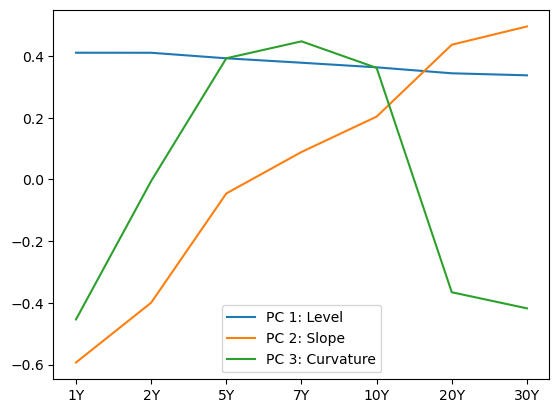

In [18]:
pca_wts = pd.DataFrame(pca.components_,columns=yields.drop(columns=["Level", "Slope", "Curvature"]).columns)
pca_wts.index = ['PC 1: Level','PC 2: Slope','PC 3: Curvature','PCA 4','PCA 5','PCA 6','PCA 7']
if pca_wts.loc['PC 3: Curvature',"10Y"]<0:
    pca_wts.loc['PC 3: Curvature'] *= -1
pca_wts.T.iloc[:,0:3].plot();

In [19]:
PCA_factors = yields.drop(columns=["Level", "Slope", "Curvature"]) @ pca_wts.iloc[:3].T

In [20]:
PCA_factors

,PC 1: Level,PC 2: Slope,PC 3: Curvature
caldt,,,
1961-06-14,9.427121,1.424204,0.156244
1961-06-15,9.489326,1.441303,0.198485
1961-06-16,9.496155,1.446733,0.202067
1961-06-19,9.530949,1.459483,0.227752
1961-06-20,9.520727,1.464235,0.187763
...,...,...,...
2024-12-24,11.843140,1.334645,-0.321412
2024-12-26,11.812885,1.341467,-0.329699
2024-12-27,11.871836,1.421227,-0.317346


<Axes: >

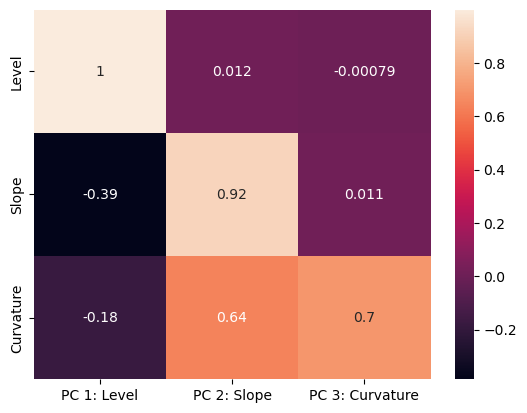

In [134]:
sns.heatmap(pd.concat([yields[["Level", "Slope", "Curvature"]], PCA_factors], axis=1, keys=['shapes', 'pca']).corr().loc['shapes', 'pca'], annot=True)